In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datasource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

learningRate=1e-4
trainSteps=500
batchSize=20
filters=(2, 4, 8, 16, 32)
strides=(2, 2, 2,  2)
resunits=1
kernelsize=3

0.4.1


float32 (256, 256) float32 (256, 256)


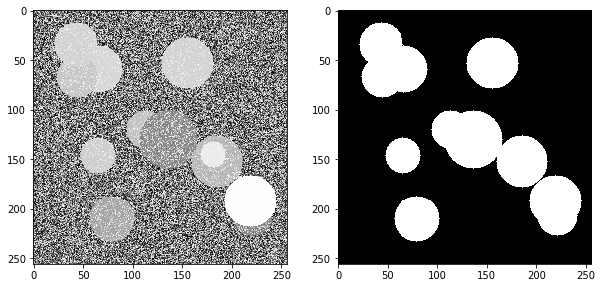

In [2]:
imwidth = 256
imheight = 256
numimgs = 500

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height),np.float32)
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,1.0,size=image.shape)
    
    return np.maximum(image,norm).astype(np.float32),(image>0).astype(np.float32)

def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
im,mask=createTestImage(imwidth,imheight)
print(im.dtype,im.shape,mask.dtype,mask.shape)
plotPair(im,mask)

float32 (500, 256, 256, 1) float32 (500, 256, 256)
float32 (1, 1, 256, 256) float32 (1, 1, 256, 256)


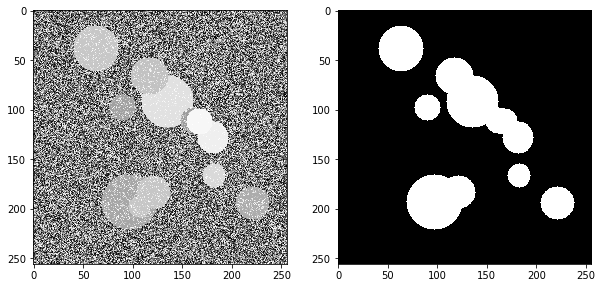

In [3]:
dataset=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

print(imgin.dtype,imgin.shape,maskin.dtype,maskin.shape)
src=datasource.DataSource(imgin,maskin,augments=[pytorchutils.convertAug])

with src.threadBatchGen(1) as gen:
    im,mask=gen()
    print(im.dtype,im.shape,mask.dtype,mask.shape)
    plotPair(im[0,0],mask[0,0])

In [4]:
class UnetMgrNB(pytorchutils.SegmentMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.SegmentMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        with self.src.threadBatchGen(self.batchSize) as gen:
            self.train(gen,self.trainSteps,1,10)
        
    def updateStep(self,step,steploss):
        self.updateGraphVals({'loss':steploss},('loss',))
        
        if step<10 or step%5==0:
            images,masks=self.traininputs
            logits,preds=self.netoutputs

            image=self.toNumpy(images[0,0])
            mask=self.toNumpy(masks[0,0])
            logit=self.toNumpy(logits[0,0])
            pred=self.toNumpy(preds[0])
            
            imgmap=OrderedDict([
                ('Image',image),
                ('Mask',mask),
                ('Logit',logit),
                ('Pred',pred),
                ('Diff',np.stack([mask,mask*pred,pred],axis=2).astype(np.float32)),
            ])
            
            self.updateImageVals(imgmap)
        

net=pytorchnet.Unet(1,1,filters,strides,kernelsize)
    
mgr=UnetMgrNB(net,src,batchSize,trainSteps)
mgr.start()

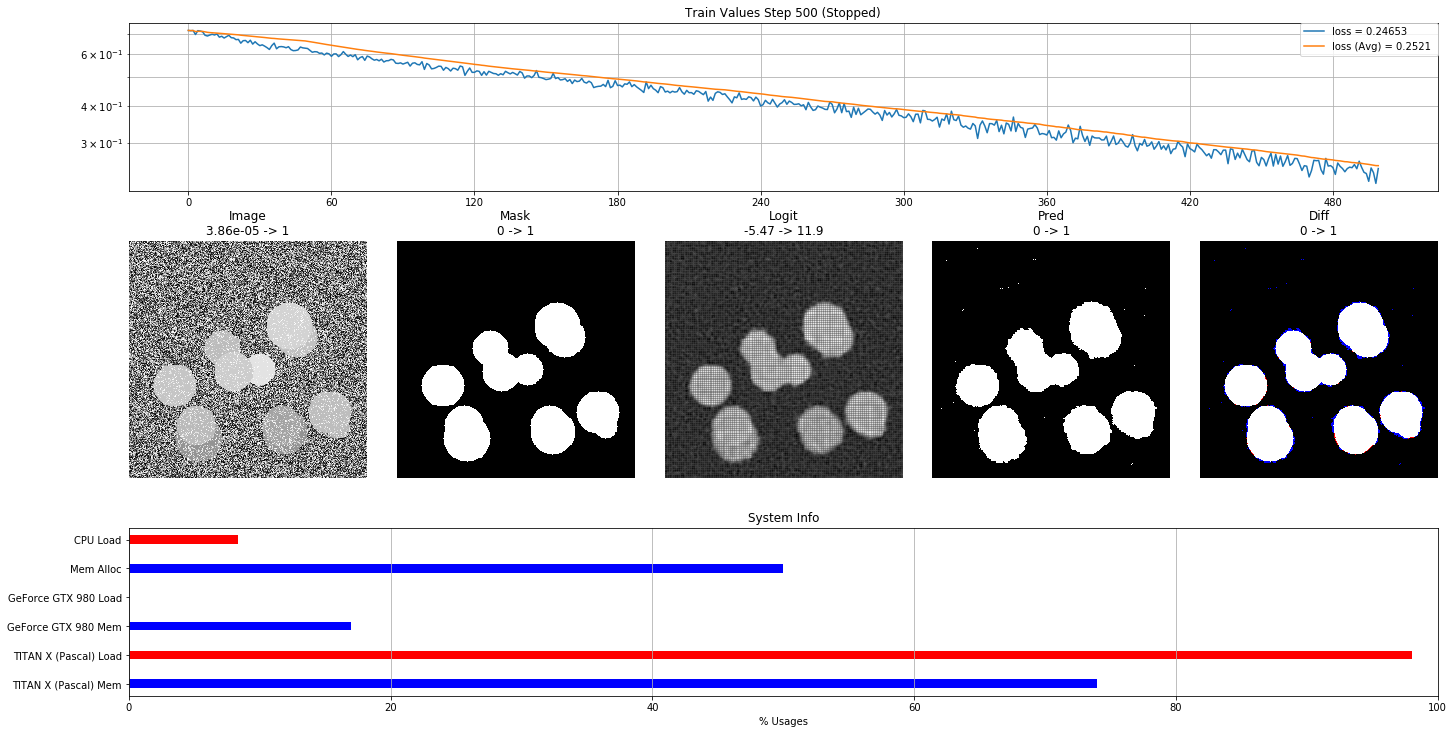

In [5]:
mgr.displayMonitor()

In [6]:
resnet=pytorchnet.Unet(1,1,filters,strides,kernelsize,numResUnits=resunits)
    
resmgr=UnetMgrNB(resnet,src,batchSize,trainSteps)
resmgr.start()

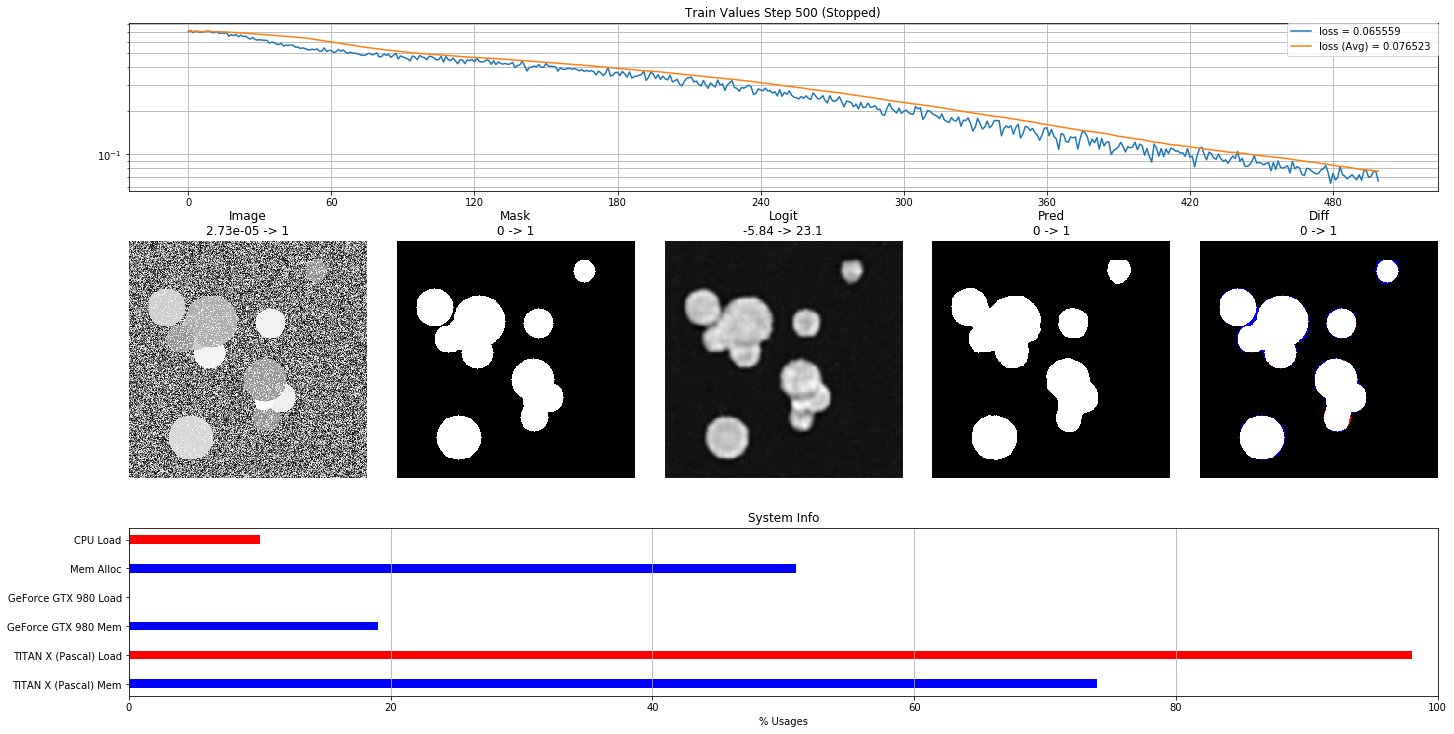

In [7]:
resmgr.displayMonitor()